# ANN_SPXW

Table of Contents
- [1. Preprocessing Data](#1-preprocessing-the-data)
- [2. Model for Calls ONLY](#2-model-for-calls-only)
  - [2.1 Stage 1 Model (Binary Classifier)](#21-stage-1-model-binary-classifier)
  - [2.2 Stage 2 Model (Price Prediction)](#22-stage-2-model-price-prediction)
  - [2.3 Testing model](#23-testing-model)
- [3. Model for Puts ONLY](#3-model-for-puts-only)
  - [3.1 Stage 1 Model (Binary Classifier)](#31-stage-1-model-binary-classifier)
  - [3.2 Stage 2 Model (Price Prediction)](#32-stage-2-model-price-prediction)
  - [3.3 Testing model](#33-testing-model)
- [4. Hyperparam Tuning](#4-hyperparam-tuning)
  - [4.1 Model for Calls ONLY](#41-model-for-calls-only)
    - [4.1.1 Hyperparam Tuning (Binary Classifier)](#411-hyperparam-tuning-binary-classifier)
    - [4.1.2 Hyperparam Tuning (Price Prediction)](#412-hyperparam-tuning-price-prediction)
  - [4.2 Model for Puts ONLY](#42-model-for-calls-only)
    - [4.2.1 Hyperparam Tuning (Binary Classifier)](#421-hyperparam-tuning-binary-classifier)
    - [4.2.2 Hyperparam Tuning (Price Prediction)](#422-hyperparam-tuning-price-prediction)

<u>Stage 1: Binary Classification Model</u>

The first model is responsible for predicting if the option is “purchasable.” It classifies the input based on whether to proceed with price prediction or not.

- Input Layer
    - 14 neurons (one for each input feature).
- Hidden Layer
    - 1 Layer, 28 neurons (Leaky RelU)
- Output Layer
    - 1 neuron with a sigmoid activation function to produce a binary result:
        - Output = 1 if the option is “purchasable” (indicating "Buy the option").
        - Output = 0 if the option is “not purchasable” (indicating "Do not buy").

<u>Stage 2: Price Prediction Model</u>

Only if the classification model predicts the option as “purchasable” (1) does the data proceed to this model. This model predicts the price of the option.

- Input Layer
    - 15 neurons (same input features as the classification model).
- Hidden Layers (Price Prediction Layer)
    - First layer, 30 neurons (Leaky ReLU)
    - Second Layer, 15 neurons (Leaky ReLU)
- Output Layer
    - 1 neuron without activation (for regression) to predict the option price.

> **Note:** The hyperparameter tuning at the end of this file can take **more than 60 minutes** to run as it uses **RandomizedSearchCV**.  
> If you are short on time, avoid running **Section 4** of this code.


# 1. Preprocessing the Data

In [125]:
import pandas as pd
import numpy as np

In [126]:
df1 = pd.read_csv('df1_modified.csv')
df3 = pd.read_csv('df2_modified.csv')
df2 = pd.read_csv('df3_modified.csv')
df4 = pd.read_csv('df4_modified.csv')
df5 = pd.read_csv('df5_modified.csv')
df6 = pd.read_csv('df6_modified.csv')

In [127]:
df_train = pd.concat([
    df1[(df1['root']=='SPXW')],
    df2[(df2['root']=='SPXW')],
    df3[(df3['root']=='SPXW')],
    df4[(df4['root']=='SPXW')],
    df5[(df5['root']=='SPXW')]
])
df_test = df6[df6['root'] == 'SPXW'].copy()

In [128]:
# Transforming relevant columns to datetime
df_train['expiration'] = pd.to_datetime(df_train['expiration'])
df_train['quote_datetime'] = pd.to_datetime(df_train['quote_datetime'])

df_test['expiration'] = pd.to_datetime(df_test['expiration'])
df_test['quote_datetime'] = pd.to_datetime(df_test['quote_datetime'])

# Calculate time-to-expiration as the difference in days
df_train['time_to_expiration'] = (df_train['expiration'] - df_train['quote_datetime']).dt.days
df_test['time_to_expiration'] = (df_test['expiration'] - df_test['quote_datetime']).dt.days

In [129]:
# New column bid_ask_spread
df_train['bid_ask_spread'] = df_train['underlying_ask'] - df_train['underlying_bid']
df_test['bid_ask_spread'] = df_test['underlying_ask'] - df_test['underlying_bid']

In [130]:
# New column is_buy, shows whether an option was bought
df_train['is_buy'] = ((df_train['trade_volume'] > 0) & (df_train['close'] != 0)).astype(int)
df_test['is_buy'] = ((df_test['trade_volume'] > 0) & (df_test['close'] != 0)).astype(int)

In [131]:
df_train_calls = df_train[df_train['option_type']=='C']
df_test_calls = df_test[df_test['option_type']=='C']

df_train_puts = df_train[df_train['option_type']=='P']
df_test_puts = df_test[df_test['option_type']=='P']

In [132]:
# Dropping irrelevant columns
# root, underlying_symbol, option_type, implied_underlying_price, quote_datetime, expiration, bid_size, ask_size, underlying_bid, underlying_ask, open, high, low
columns_to_drop = ['root', 'option_type','underlying_symbol', 'implied_underlying_price', 'quote_datetime', 
                   'expiration', 'open', 'high', 'low', 'bid_size', 'ask_size', 'time_to_maturity',
                   'underlying_bid', 'underlying_ask', 'bid','ask']

df_train_calls = df_train_calls.drop(columns = columns_to_drop, axis=1)
df_train_puts = df_train_puts.drop(columns = columns_to_drop, axis=1)
df_test_calls = df_test_calls.drop(columns = columns_to_drop, axis=1)
df_test_puts = df_test_puts.drop(columns = columns_to_drop, axis=1)

# 2. Model for Calls ONLY

In [133]:
# Scaling features
from sklearn.preprocessing import StandardScaler

numerical_columns = ['strike', 'trade_volume', 'active_underlying_price', 
                     'implied_volatility', 'delta', 'gamma', 'theta', 'close',
                     'vega', 'rho', 'open_interest', 'risk_free_rate', 'time_to_expiration', 'bid_ask_spread']
scaler = StandardScaler()
df_train_calls[numerical_columns] = scaler.fit_transform(df_train_calls[numerical_columns])
df_test_calls[numerical_columns] = scaler.transform(df_test_calls[numerical_columns])

## 2.1 Stage 1 Model (Binary Classifier)

The followering hyper parameters were determined in [Section 4.1.1](#411-hyperparam-tuning-binary-classifier) of hyperparameter tuning.
- Hidden Layer No. of Neurons: 56
- Model Learning Rate: 0.001
- Epochs: 20
- Batch Size: 32

In [134]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LeakyReLU
from tensorflow.keras.optimizers import Adam

# Define the binary classifier model
binary_classifier_calls = Sequential()

# Input layer with 14 neurons for 14 features
binary_classifier_calls.add(Input(shape=(14,)))

# Hidden layer with 56 neurons
binary_classifier_calls.add(Dense(units=56))
binary_classifier_calls.add(LeakyReLU(negative_slope=0.01))         # Leaky ReLU activation

# Output layer with 1 neuron and sigmoid activation for binary classification
binary_classifier_calls.add(Dense(1, activation='sigmoid'))

# Compile the model with binary cross-entropy loss and Adam optimizer
binary_classifier_calls.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
binary_classifier_calls.summary()


Model: "sequential_136"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_340 (Dense)               │ (None, 56)             │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_204 (LeakyReLU)     │ (None, 56)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_341 (Dense)               │ (None, 1)              │            57 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 897 (3.50 KB)

 Trainable params: 897 (3.50 KB)

 Non-trainable params: 0 (0.00 B)

In [135]:
# Separate features and target for training
X_train = df_train_calls.drop(columns=['option_price', 'is_buy'])  # Drop 'close' and 'is_buy' from features
y_train = df_train_calls['is_buy']  # Target for binary classification

In [136]:
# Training the binary classifier
history = binary_classifier_calls.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20
7205/7205 ━━━━━━━━━━━━━━━━━━━━ 2s 268us/step - accuracy: 0.9635 - loss: 0.1019 - val_accuracy: 0.9943 - val_loss: 0.0190
Epoch 2/20
7205/7205 ━━━━━━━━━━━━━━━━━━━━ 2s 258us/step - accuracy: 0.9934 - loss: 0.0203 - val_accuracy: 0.9964 - val_loss: 0.0155
Epoch 3/20
7205/7205 ━━━━━━━━━━━━━━━━━━━━ 2s 251us/step - accuracy: 0.9950 - loss: 0.0150 - val_accuracy: 0.9964 - val_loss: 0.0110
Epoch 4/20
7205/7205 ━━━━━━━━━━━━━━━━━━━━ 2s 247us/step - accuracy: 0.9955 - loss: 0.0133 - val_accuracy: 0.9962 - val_loss: 0.0101
Epoch 5/20
7205/7205 ━━━━━━━━━━━━━━━━━━━━ 2s 248us/step - accuracy: 0.9964 - loss: 0.0115 - val_accuracy: 0.9975 - val_loss: 0.0086
Epoch 6/20
7205/7205 ━━━━━━━━━━━━━━━━━━━━ 2s 247us/step - accuracy: 0.9970 - loss: 0.0097 - val_accuracy: 0.9969 - val_loss: 0.0080
Epoch 7/20
7205/7205 ━━━━━━━━━━━━━━━━━━━━ 2s 252us/step - accuracy: 0.9968 - loss: 0.0098 - val_accuracy: 0.9973 - val_loss: 0.0075
Epoch 8/20
7205/7205 ━━━━━━━━━━━━━━━━━━━━ 2s 248us/step - accuracy: 0.9972 -

In [137]:
import matplotlib.pyplot as plt

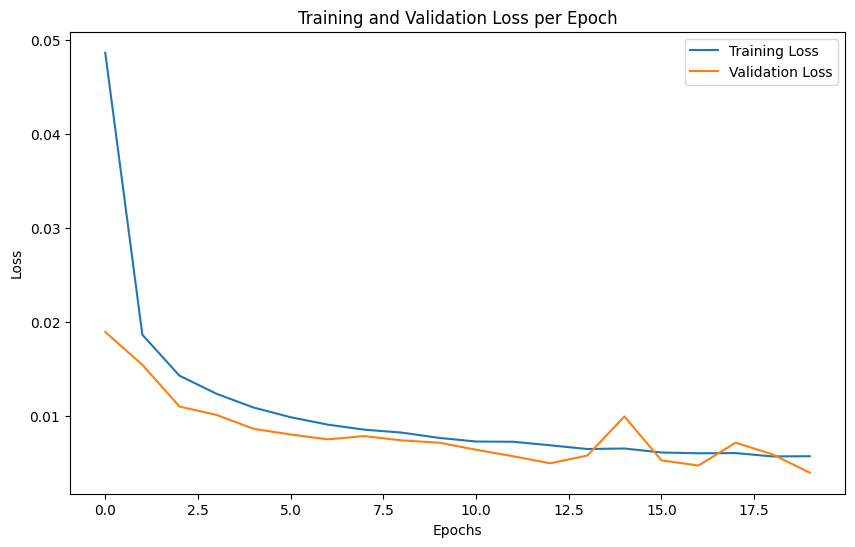

In [138]:
# Extracting training and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting the losses per epoch
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.show()

In [139]:
# Separate features and target for the price prediction model
X_train_calls = df_train_calls.drop(columns=['is_buy','option_price'])  # Features for price prediction
y_train_price_full = df_train_calls['option_price']  # Target price

# Generate the 'purchasable' predictions using the classifier
purchasable_mask = binary_classifier_calls.predict(X_train_calls) >= 1  # Prediction mask for purchasable options

# Filter rows for the price prediction model based on the 'purchasable' mask
X_train_price = X_train_calls[purchasable_mask.flatten()]  # Only rows classified as purchasable
y_train_price = y_train_price_full[purchasable_mask.flatten()]  # Corresponding target prices for purchasable options

9007/9007 ━━━━━━━━━━━━━━━━━━━━ 2s 165us/step


## 2.2 Stage 2 Model (Price Prediction)

The followering hyper parameters were determined in [Section 4.1.2](#412-hyperparam-tuning-price-prediction) of hyperparameter tuning.
- Hidden Layer 1 No. of Neurons: 56
- Hidden Layer 2 No. of Neurons: 28
- Model Learning Rate: 0.001
- Epochs: 30
- Batch Size: 32

In [140]:
# Define the price prediction model
price_prediction_model_calls = Sequential()

# Input layer with 14 neurons
price_prediction_model_calls.add(Input(shape=(14,))) 

# First hidden layer with 56 neurons
price_prediction_model_calls.add(Dense(units=56))  
price_prediction_model_calls.add(LeakyReLU(negative_slope=0.01))               # Leaky ReLU activation

# Second hidden layer with 28 neurons and Leaky ReLU activation
price_prediction_model_calls.add(Dense(units=28))
price_prediction_model_calls.add(LeakyReLU(negative_slope=0.01))

# Output layer with 1 neuron (no activation for regression)
price_prediction_model_calls.add(Dense(units=1))

# Compile the model with Mean Squared Error (MSE) as the loss function for regression
price_prediction_model_calls.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Summary of the model architecture
price_prediction_model_calls.summary()


Model: "sequential_137"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_342 (Dense)               │ (None, 56)             │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_205 (LeakyReLU)     │ (None, 56)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_343 (Dense)               │ (None, 28)             │         1,596 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_206 (LeakyReLU)     │ (None, 28)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_344 (Dense)               │ (None, 1)              │            29 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,465 (9.63 KB)

 Trainable params: 2,465 (9.63 KB)

 Non-trainable params: 0 (0.00 B)

In [141]:
# Train the price prediction model
history = price_prediction_model_calls.fit(X_train_price, y_train_price, epochs=30, batch_size=32, validation_split=0.2)

Epoch 1/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 1s 351us/step - loss: 52468.1680 - val_loss: 881.6105
Epoch 2/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step - loss: 288.4718 - val_loss: 98.8142
Epoch 3/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step - loss: 47.9892 - val_loss: 55.4875
Epoch 4/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step - loss: 31.3841 - val_loss: 36.6341
Epoch 5/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step - loss: 24.0614 - val_loss: 31.9630
Epoch 6/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step - loss: 21.8237 - val_loss: 21.8088
Epoch 7/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step - loss: 18.8552 - val_loss: 16.1119
Epoch 8/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step - loss: 17.5775 - val_loss: 16.6244
Epoch 9/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step - loss: 17.6951 - val_loss: 14.4236
Epoch 10/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step - loss: 16.9942 - val_loss: 14.5763
Epoch 11/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step - loss: 16.9636 - val_loss: 11.0518
Epo

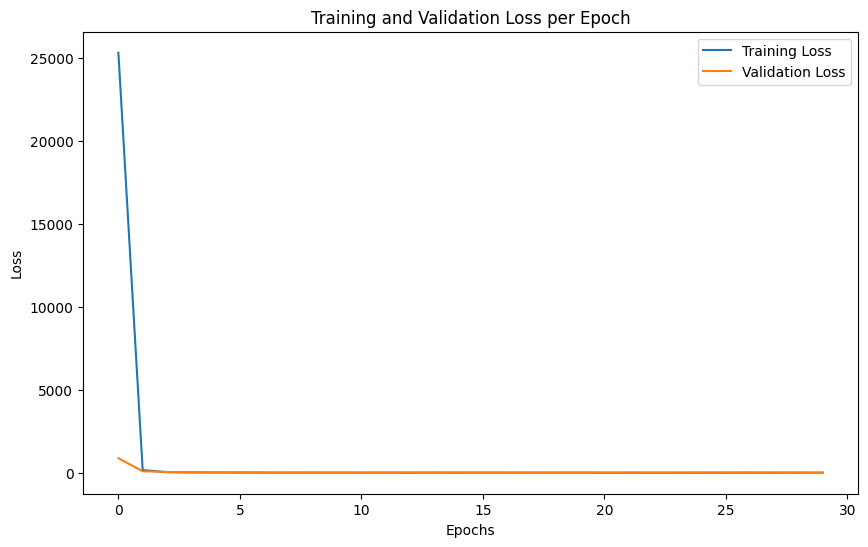

In [142]:
# Extracting training and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting the losses per epoch
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.show()

## 2.3 Testing model

Testing is performed on a 6th day of trading not included in the training data

In [143]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [144]:
# Features and target for binary classification model
X_test_classification = df_test_calls.drop(columns=['option_price', 'is_buy'])  # Features for binary classification
y_test_classification = df_test_calls['is_buy']           # Binary target for classification

# Features and target for price prediction model
X_test_price = df_test_calls.drop(columns=['is_buy', 'option_price'])  # Features for price prediction
y_test_price_full = df_test_calls['option_price']                      # Target price for price prediction

In [145]:
y_pred_binary = (binary_classifier_calls.predict(X_test_classification).flatten() >= 0.5).astype(int)

# Calculate binary classifier metrics
binary_accuracy = accuracy_score(y_test_classification, y_pred_binary)
binary_precision = precision_score(y_test_classification, y_pred_binary)
binary_recall = recall_score(y_test_classification, y_pred_binary)
binary_f1 = f1_score(y_test_classification, y_pred_binary)

print("Binary Classifier Metrics:")
print(f"Accuracy: {binary_accuracy}")
print(f"Precision: {binary_precision}")
print(f"Recall: {binary_recall}")
print(f"F1-Score: {binary_f1}")


1769/1769 ━━━━━━━━━━━━━━━━━━━━ 0s 164us/step
Binary Classifier Metrics:
Accuracy: 0.9984982862796368
Precision: 1.0
Recall: 0.9861247143323539
F1-Score: 0.9930138900304101


In [146]:
# Step 2: Filter Data for Stage 2 Price Prediction
purchasable_mask = (y_pred_binary == 1)  # Mask for options classified as "purchasable"

# Apply the mask to get features and target for price prediction
X_test_price_purchasable = X_test_price[purchasable_mask]
y_test_price = y_test_price_full[purchasable_mask]

In [147]:
# Step 3: Run Stage 2 Price Prediction
if len(X_test_price_purchasable) > 0:
    y_pred_price = price_prediction_model_calls.predict(X_test_price_purchasable)

    # Calculate regression metrics
    mse = mean_squared_error(y_test_price, y_pred_price)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_price, y_pred_price)
    r2 = r2_score(y_test_price, y_pred_price)

    print("\nPrice Prediction Model Metrics:")
    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {rmse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R-squared: {r2}")
else:
    print("\nNo 'purchasable' options found for price prediction in the 6th day test set.")

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 232us/step

Price Prediction Model Metrics:
Mean Squared Error: 13.875311079949062
Root Mean Squared Error: 3.7249578628420834
Mean Absolute Error: 2.1343401358629213
R-squared: 0.9996872496471988


# 3. Model for Puts ONLY

In [148]:
# Scaling
numerical_columns = ['strike', 'close', 'trade_volume', 'active_underlying_price', 
                     'implied_volatility', 'delta', 'gamma', 'theta', 
                     'vega', 'rho', 'open_interest', 'risk_free_rate', 'time_to_expiration', 'bid_ask_spread']
scaler = StandardScaler()
df_train_puts[numerical_columns] = scaler.fit_transform(df_train_puts[numerical_columns])
df_test_puts[numerical_columns] = scaler.transform(df_test_puts[numerical_columns])

## 3.1 Stage 1 Model (Binary Classifier)

The followering hyper parameters were determined in [Section 4.2.1](#421-hyperparam-tuning-binary-classifier) of hyperparameter tuning.
- Hidden Layer No. of Neurons: 56
- Model Learning Rate: 0.001
- Epochs: 20
- Batch Size: 32

In [149]:
# Define the binary classifier model
binary_classifier_puts = Sequential()

# Input layer with 14 neurons for 14 features
binary_classifier_puts.add(Input(shape=(14,)))

# Hidden layer with 56 neurons
binary_classifier_puts.add(Dense(units=56))
binary_classifier_puts.add(LeakyReLU(negative_slope=0.01))         # Leaky ReLU activation

# Output layer with 1 neuron and sigmoid activation for binary classification
binary_classifier_puts.add(Dense(1, activation='sigmoid'))

# Compile the model with binary cross-entropy loss and Adam optimizer
binary_classifier_puts.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
binary_classifier_puts.summary()


Model: "sequential_138"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_345 (Dense)               │ (None, 56)             │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_207 (LeakyReLU)     │ (None, 56)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_346 (Dense)               │ (None, 1)              │            57 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 897 (3.50 KB)

 Trainable params: 897 (3.50 KB)

 Non-trainable params: 0 (0.00 B)

In [150]:
# Separate features and target for training
X_train = df_train_puts.drop(columns=['option_price', 'is_buy'])  # Drop 'close' and 'is_buy' from features
y_train = df_train_puts['is_buy']  # Target for binary classification

In [151]:
# Training the binary classifier
history = binary_classifier_puts.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
7205/7205 ━━━━━━━━━━━━━━━━━━━━ 3s 330us/step - accuracy: 0.9501 - loss: 0.1357 - val_accuracy: 0.9890 - val_loss: 0.0315
Epoch 2/20
7205/7205 ━━━━━━━━━━━━━━━━━━━━ 2s 240us/step - accuracy: 0.9914 - loss: 0.0274 - val_accuracy: 0.9951 - val_loss: 0.0213
Epoch 3/20
7205/7205 ━━━━━━━━━━━━━━━━━━━━ 2s 245us/step - accuracy: 0.9939 - loss: 0.0192 - val_accuracy: 0.9953 - val_loss: 0.0154
Epoch 4/20
7205/7205 ━━━━━━━━━━━━━━━━━━━━ 2s 239us/step - accuracy: 0.9953 - loss: 0.0151 - val_accuracy: 0.9977 - val_loss: 0.0160
Epoch 5/20
7205/7205 ━━━━━━━━━━━━━━━━━━━━ 2s 240us/step - accuracy: 0.9959 - loss: 0.0134 - val_accuracy: 0.9956 - val_loss: 0.0143
Epoch 6/20
7205/7205 ━━━━━━━━━━━━━━━━━━━━ 2s 237us/step - accuracy: 0.9962 - loss: 0.0120 - val_accuracy: 0.9973 - val_loss: 0.0096
Epoch 7/20
7205/7205 ━━━━━━━━━━━━━━━━━━━━ 2s 237us/step - accuracy: 0.9967 - loss: 0.0107 - val_accuracy: 0.9981 - val_loss: 0.0097
Epoch 8/20
7205/7205 ━━━━━━━━━━━━━━━━━━━━ 2s 242us/step - accuracy: 0.9969 -

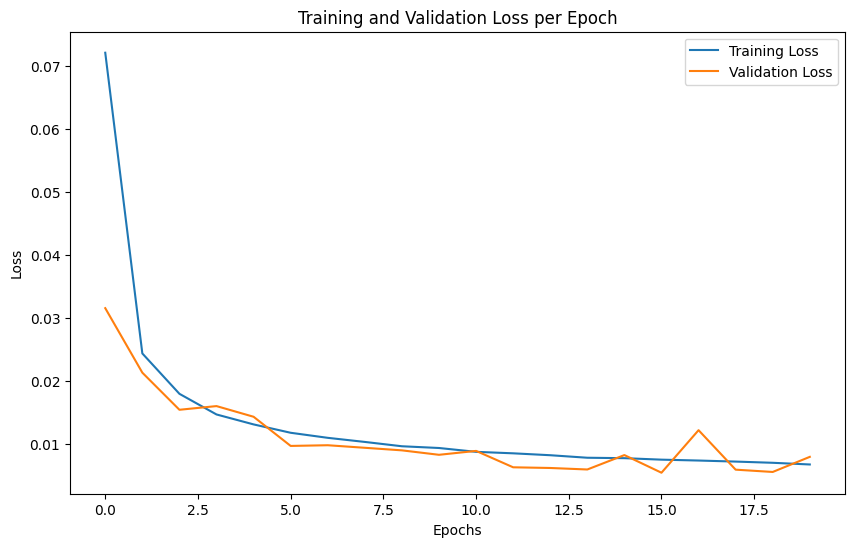

In [152]:
# Extracting training and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting the losses per epoch
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.show()

In [153]:
# Separate features and target for the price prediction model
X_train_puts = df_train_puts.drop(columns=['is_buy','option_price'])  # Features for price prediction
y_train_price_full = df_train_puts['option_price']  # Target price

# Generate the 'purchasable' predictions using the classifier
purchasable_mask = binary_classifier_puts.predict(X_train_puts) >= 1  # Prediction mask for purchasable options

# Filter rows for the price prediction model based on the 'purchasable' mask
X_train_price = X_train_puts[purchasable_mask.flatten()]  # Only rows classified as purchasable
y_train_price = y_train_price_full[purchasable_mask.flatten()]  # Corresponding target prices for purchasable options

9007/9007 ━━━━━━━━━━━━━━━━━━━━ 2s 165us/step


## 3.2 Stage 2 Model (Price Prediction)

The followering hyper parameters were determined in [Section 4.2.2](#422-hyperparam-tuning-price-prediction) of hyperparameter tuning.
- Hidden Layer 1 No. of Neurons: 28
- Hidden Layer 2 No. of Neurons: 14
- Model Learning Rate: 0.001
- Epochs: 10
- Batch Size: 64

In [154]:
# Define the price prediction model
price_prediction_model_puts = Sequential()

# Input layer with 14 neurons and first hidden layer with 28 neurons
price_prediction_model_puts.add(Input(shape=(14,)))
price_prediction_model_puts.add(Dense(units=28))
price_prediction_model_puts.add(LeakyReLU(negative_slope=0.01))               # Leaky ReLU activation

# Second hidden layer with 14 neurons and Leaky ReLU activation
price_prediction_model_puts.add(Dense(units=14))
price_prediction_model_puts.add(LeakyReLU(negative_slope=0.01))

# Output layer with 1 neuron (no activation for regression)
price_prediction_model_puts.add(Dense(units=1))

# Compile the model with Mean Squared Error (MSE) as the loss function for regression
price_prediction_model_puts.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Summary of the model architecture
price_prediction_model_puts.summary()


Model: "sequential_139"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_347 (Dense)               │ (None, 28)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_208 (LeakyReLU)     │ (None, 28)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_348 (Dense)               │ (None, 14)             │           406 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_209 (LeakyReLU)     │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_349 (Dense)               │ (None, 1)              │            15 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 841 (3.29 KB)

 Trainable params: 841 (3.29 KB)

 Non-trainable params: 0 (0.00 B)

In [155]:
# Train the price prediction model
history = price_prediction_model_puts.fit(X_train_price, y_train_price, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 4157.3262 - val_loss: 1596.9462
Epoch 2/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step - loss: 548.8592 - val_loss: 217.3173
Epoch 3/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step - loss: 79.9752 - val_loss: 54.7114
Epoch 4/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step - loss: 18.3508 - val_loss: 27.1064
Epoch 5/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step - loss: 11.6670 - val_loss: 14.4945
Epoch 6/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step - loss: 8.9152 - val_loss: 11.1056
Epoch 7/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step - loss: 7.4460 - val_loss: 8.0170
Epoch 8/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step - loss: 6.8305 - val_loss: 6.0150
Epoch 9/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step - loss: 6.0873 - val_loss: 5.0809
Epoch 10/10
555/555 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step - loss: 5.5455 - val_loss: 4.7131


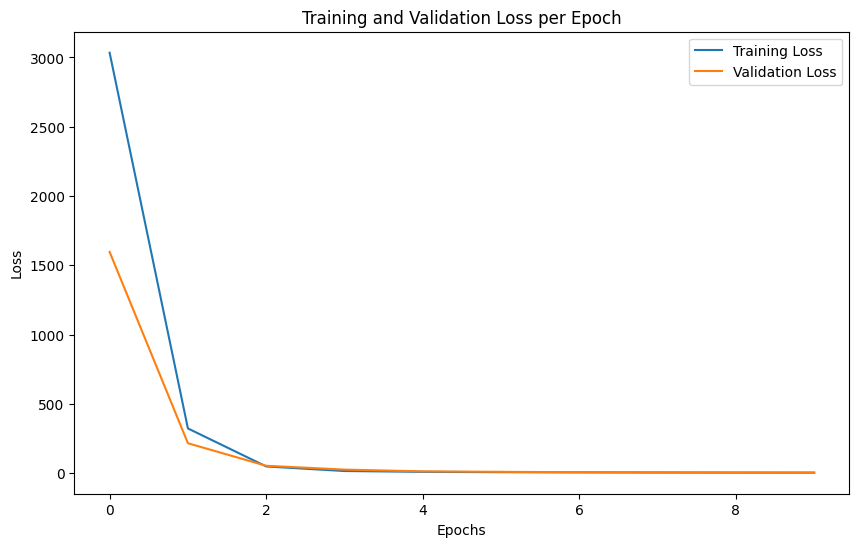

In [156]:
# Extracting training and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting the losses per epoch
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.show()

## 3.3 Testing model

Testing is performed on a 6th day of trading not included in the training data

In [157]:
# Features and target for binary classification model
X_test_classification = df_test_puts.drop(columns=['option_price', 'is_buy'])  # Features for binary classification
y_test_classification = df_test_puts['is_buy']           # Binary target for classification

# Features and target for price prediction model
X_test_price = df_test_puts.drop(columns=['is_buy', 'option_price'])  # Features for price prediction
y_test_price_full = df_test_puts['option_price']                      # Target price for price prediction

In [158]:
y_pred_binary = (binary_classifier_puts.predict(X_test_classification).flatten() >= 0.5).astype(int)

# Calculate binary classifier metrics
binary_accuracy = accuracy_score(y_test_classification, y_pred_binary)
binary_precision = precision_score(y_test_classification, y_pred_binary)
binary_recall = recall_score(y_test_classification, y_pred_binary)
binary_f1 = f1_score(y_test_classification, y_pred_binary)

print("Binary Classifier Metrics:")
print(f"Accuracy: {binary_accuracy}")
print(f"Precision: {binary_precision}")
print(f"Recall: {binary_recall}")
print(f"F1-Score: {binary_f1}")


1769/1769 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step
Binary Classifier Metrics:
Accuracy: 0.9968552347973569
Precision: 1.0
Recall: 0.982713411673303
F1-Score: 0.9912813479623824


In [159]:
# Step 2: Filter Data for Stage 2 Price Prediction
purchasable_mask = (y_pred_binary == 1)  # Mask for options classified as "purchasable"

# Apply the mask to get features and target for price prediction
X_test_price_purchasable = X_test_price[purchasable_mask]
y_test_price = y_test_price_full[purchasable_mask]

In [160]:
# Step 3: Run Stage 2 Price Prediction
if len(X_test_price_purchasable) > 0:
    y_pred_price = price_prediction_model_puts.predict(X_test_price_purchasable)

    # Calculate regression metrics
    mse = mean_squared_error(y_test_price, y_pred_price)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_price, y_pred_price)
    r2 = r2_score(y_test_price, y_pred_price)

    print("\nPrice Prediction Model Metrics:")
    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {rmse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R-squared: {r2}")
else:
    print("\nNo 'purchasable' options found for price prediction in the 6th day test set.")

317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step

Price Prediction Model Metrics:
Mean Squared Error: 6.957355757114937
Root Mean Squared Error: 2.63767999520695
Mean Absolute Error: 1.6335359660518158
R-squared: 0.998123988141348


# 4. Hyperparam Tuning

In this section, hyperparameter tuning will be conducted using random search cv to randomly iterate through combinations of values in a parameter grid. This has previously been used by our group to arrive at the parameters we have input to our models above. 

> **Note:** The hyperparameter tuning in this section can take **more than 60 minutes** to run as it uses **RandomizedSearchCV**.  
> If you are short on time, avoid running **Section 4** of this code.

In [74]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV 
from scikeras.wrappers import KerasRegressor

## 4.1 Model for Calls ONLY

### 4.1.1 Hyperparam Tuning (Binary Classifier)

In [75]:
# Define the model-building function for Random Search
def build_binary_classifier_model(units=28, learning_rate=1e-3):
    model = Sequential()
    
    # Define the input layer separately using Input()
    model.add(Input(shape=(14,)))
    
    # Hidden layer with Leaky ReLU activation (using `negative_slope` instead of `alpha`)
    model.add(Dense(units=units))
    model.add(LeakyReLU(negative_slope=0.01))
    
    # Output layer with 1 neuron and sigmoid activation for binary classification
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model with specified learning rate
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Wrap the model using KerasClassifier, passing the function as build_fn
binary_classifier = KerasClassifier(model=build_binary_classifier_model, verbose=0)


In [76]:
param_grid = {
    'model__units': [14, 28, 56],            # Number of neurons in the hidden layer
    'model__learning_rate': [1e-2, 1e-3, 1e-4],  # Learning rates to try
    'batch_size': [16, 32, 64],              # Batch sizes to try
    'epochs': [10, 20]                       # Number of epochs to train
}

In [77]:
# Initialize RandomizedSearchCV with the desired number of iterations
random_search = RandomizedSearchCV(estimator=binary_classifier, param_distributions=param_grid, 
                                   scoring='accuracy', cv=3, n_iter=10, random_state=42)

# Fit RandomizedSearchCV
X_train = df_train_calls.drop(columns=['option_price', 'is_buy'])  # Drop 'close' and 'is_buy' from features
y_train = df_train_calls['is_buy']  # Target for binary classification
random_search_result = random_search.fit(X_train, y_train)

# Get the best hyperparameters and score
print(f"Best Hyperparameters: {random_search_result.best_params_}")
print(f"Best Score: {random_search_result.best_score_}")


Best Hyperparameters: {'model__units': 56, 'model__learning_rate': 0.001, 'epochs': 20, 'batch_size': 32}
Best Score: 0.998372641093061


### 4.1.2 Hyperparam Tuning (Price Prediction)

In [78]:
# Define the model-building function
def build_price_prediction_model(units1=28, units2=14, learning_rate=1e-3):
    model = Sequential()
    
    # Input and first hidden layer
    model.add(Input(shape=(14,)))
    model.add(Dense(units=units1))
    model.add(LeakyReLU(negative_slope=0.01))
    
    # Second hidden layer
    model.add(Dense(units=units2))
    model.add(LeakyReLU(negative_slope=0.01))
    
    # Output layer
    model.add(Dense(units=1))  # No activation function for regression
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

In [79]:
# Wrap the model with KerasRegressor
price_prediction_model = KerasRegressor(model=build_price_prediction_model, verbose=0)

In [80]:
param_grid = {
    'model__units1': [14, 28, 56],               # Number of neurons in the first hidden layer
    'model__units2': [7, 14, 28],                # Number of neurons in the second hidden layer
    'model__learning_rate': [1e-2, 1e-3, 1e-4],  # Learning rates to try
    'batch_size': [16, 32, 64],                  # Batch sizes to try
    'epochs': [10, 20, 30]                           # Number of epochs
}

In [81]:
# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=price_prediction_model, param_distributions=param_grid, 
                                   scoring='neg_mean_squared_error', n_iter=10, cv=3, random_state=42)

# Fit RandomizedSearchCV
X_train = df_train_calls.drop(columns=['option_price', 'is_buy'])  # Features for training
y_train = df_train_calls['option_price']  # Target prices for training
random_search_result = random_search.fit(X_train, y_train)

# Get the best hyperparameters and score
print(f"Best Hyperparameters: {random_search_result.best_params_}")
print(f"Best Score (Negative MSE): {random_search_result.best_score_}")


Best Hyperparameters: {'model__units2': 28, 'model__units1': 56, 'model__learning_rate': 0.001, 'epochs': 30, 'batch_size': 32}
Best Score (Negative MSE): -21.242516936843707


## 4.2 Model for Puts ONLY

### 4.2.1 Hyperparam Tuning (Binary Classifier)

In [82]:
# Define the model-building function for Random Search
def build_binary_classifier_model(units=28, learning_rate=1e-3):
    model = Sequential()
    
    # Define the input layer separately using Input()
    model.add(Input(shape=(14,)))
    
    # Hidden layer with Leaky ReLU activation (using `negative_slope` instead of `alpha`)
    model.add(Dense(units=units))
    model.add(LeakyReLU(negative_slope=0.01))
    
    # Output layer with 1 neuron and sigmoid activation for binary classification
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model with specified learning rate
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Wrap the model using KerasClassifier, passing the function as build_fn
binary_classifier = KerasClassifier(model=build_binary_classifier_model, verbose=0)


In [83]:
param_grid = {
    'model__units': [14, 28, 56],            # Number of neurons in the hidden layer
    'model__learning_rate': [1e-2, 1e-3, 1e-4],  # Learning rates to try
    'batch_size': [16, 32, 64],              # Batch sizes to try
    'epochs': [10, 20]                       # Number of epochs to train
}

In [84]:
from sklearn.model_selection import RandomizedSearchCV

# Initialize RandomizedSearchCV with the desired number of iterations
random_search = RandomizedSearchCV(estimator=binary_classifier, param_distributions=param_grid, 
                                   scoring='accuracy', cv=3, n_iter=10, random_state=42)

# Fit RandomizedSearchCV
X_train = df_train_puts.drop(columns=['option_price', 'is_buy'])  # Drop 'close' and 'is_buy' from features
y_train = df_train_puts['is_buy']  # Target for binary classification
random_search_result = random_search.fit(X_train, y_train)

# Get the best hyperparameters and score
print(f"Best Hyperparameters: {random_search_result.best_params_}")
print(f"Best Score: {random_search_result.best_score_}")


Best Hyperparameters: {'model__units': 56, 'model__learning_rate': 0.001, 'epochs': 20, 'batch_size': 32}
Best Score: 0.9974427259385094


### 4.2.2 Hyperparam Tuning (Price Prediction)

In [85]:
# Define the model-building function
def build_price_prediction_model(units1=28, units2=14, learning_rate=1e-3):
    model = Sequential()
    
    # Input and first hidden layer
    model.add(Input(shape=(14,)))
    model.add(Dense(units=units1))
    model.add(LeakyReLU(negative_slope=0.01))
    
    # Second hidden layer
    model.add(Dense(units=units2))
    model.add(LeakyReLU(negative_slope=0.01))
    
    # Output layer
    model.add(Dense(units=1))  # No activation function for regression
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

In [86]:
# Wrap the model with KerasRegressor
price_prediction_model = KerasRegressor(model=build_price_prediction_model, verbose=0)

In [87]:
param_grid = {
    'model__units1': [14, 28, 56],               # Number of neurons in the first hidden layer
    'model__units2': [7, 14, 28],                # Number of neurons in the second hidden layer
    'model__learning_rate': [1e-2, 1e-3, 1e-4],  # Learning rates to try
    'batch_size': [16, 32, 64],                  # Batch sizes to try
    'epochs': [10, 20, 30]                           # Number of epochs
}

In [88]:
# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=price_prediction_model, param_distributions=param_grid, 
                                   scoring='neg_mean_squared_error', n_iter=10, cv=3, random_state=42)

# Fit RandomizedSearchCV
X_train = df_train_puts.drop(columns=['option_price', 'is_buy'])  # Features for training
y_train = df_train_puts['option_price']  # Target prices for training
random_search_result = random_search.fit(X_train, y_train)


# Get the best hyperparameters and score
print(f"Best Hyperparameters: {random_search_result.best_params_}")
print(f"Best Score (Negative MSE): {random_search_result.best_score_}")


Best Hyperparameters: {'model__units2': 14, 'model__units1': 28, 'model__learning_rate': 0.001, 'epochs': 10, 'batch_size': 64}
Best Score (Negative MSE): -17.873166131017545
